<a href="https://colab.research.google.com/github/RoaldKhairov/skill_project/blob/master/ltv_predict/LTV_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
#!pip install plotly
#!pip install catb
#!pip install catboost
#!pip install shap

In [52]:
import sys
import pandas as pd
import numpy as np
from datetime import timedelta 
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from plotly import graph_objs as go
from dateutil.relativedelta import relativedelta
import warnings
import shap
import warnings
warnings.filterwarnings("ignore")

# Прогноз LTV

К примеру, прогноз LTV на требуемый горизонт позволяет оценить эффективность рекламных компаний за короткий промежуток времени и перенаправить средтсва на более выгодные канали. 
Обычно в качестве горизонта выбирают одно из следующих значений: 30 дней, 90 дней, 180 дней, один год или два года. Для удобства последующего изложения материала будем считать, что горизонт прогнозирования равен 180-и дням. Для любых других горизонтов логика останется точно такой же.

Первое, с чем следует разобраться, это период ожидания накопления данных. Если его сделать очень большим, например 180 дней, то к моменту прогнозирования уже будет известна реальное значение LTV. Такой подход не эффективен и все решения будут приниматься по уже по факту. Другая крайность - не ждать данные вовсе, и уже через час после установки строить прогноз. При таком подходе существует вероятность, что не будет собраны признаки, с помощью которых можно сделать качественно прогнозирование. **Поэтому золотой серединой является выбор периода данных равным 8 дням**. С одной стороны есть возможность принять решение на основе полученных прогнозов и перенаправить бюджеты, с другой стороны - есть время на сбор признаков, которые обеспечат качество прогноза.

И так, имеется информация о первых 8 днях жизни. Для построения прогноза необходимы данные о платежах — это главная вводная,
без которой нельзя спрогнозировать доход.

Дополнительно можно использовать информацию о запусках и сессиях, соцдем-признаки и информацию о партнере и кампании, которая привела устройство.
 
По итогу, будем использовать данные о платежах и типе трафика: органический или платный.

In [53]:
# id гугл диска
! gdown --id 18TUsG5G5ER_Xqn4J6qHqnslqPT0t64Q6

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=18TUsG5G5ER_Xqn4J6qHqnslqPT0t64Q6
To: /content/cookie_cats.csv
100% 2.80M/2.80M [00:00<00:00, 115MB/s]


# Описание данных



В файле  big_data.csv  содержатся данные о сырых транзакциях устройств для большого приложения, есть следующие поля:\

**idCountry**  - страна пользователя

**dtInstall**  - дата установки пользователя

**dtEvent**  - дата платежа

**idTrafficType**  - тип трафика, с которого установил пользователь

**sumUsd**  - размер платежа в долларах

**device_id**  - id устройства

В файле  **small_data.csv ** содержатся данные о куммулятивном (накопленном) ltv устройств, есть следующие поля:\

**install_date**  - дата установки пользователя

**ltvDay1,.., ltvDay8**  - накопленный ltv с 1 по 8 день жизни

**device_id**  - id устройства

In [54]:
big_data = pd.read_csv('/content/drive/MyDrive/dataset/big_data.csv')
small_data = pd.read_csv('/content/drive/MyDrive/dataset/small_data.csv')

# Модель катбуста и линейной регресии

In [55]:
print("Размер датасета: ", big_data.shape)
print("Минимальная дата: ", big_data.dtInstall.min())
print("Максимальная дата: ", big_data.dtInstall.max())
print(big_data.head(5))

Размер датасета:  (914744, 6)
Минимальная дата:  2021-01-02
Максимальная дата:  2021-10-29
   idCountry   dtInstall     dtEvent  idTrafficType  sumUsd       device_id
0         76  2021-10-16  2022-04-13              1   18.91  device_0000001
1        202  2021-10-28  2022-05-03              1    2.85  device_0000002
2        202  2021-10-28  2022-04-04              1    3.57  device_0000002
3         81  2021-10-02  2022-04-06              2   28.27  device_0000003
4         81  2021-10-02  2022-04-03              2    2.90  device_0000003


Каждая строчка - это платеж устройства, также есть сумма платежа в долларах, дата установки, дата платежа, тип траффика и страна.

Введем дополнительный столбец, который показывает, сколько дней прошло от даты устаноовки до даты платежа, в дальнейшем он нам потребуется.

In [56]:
big_data['timedelta'] = (pd.to_datetime(big_data.dtEvent) - pd.to_datetime(big_data.dtInstall)).apply(lambda x: x.days)

Начнем готовить признаки для модели. В виде сырых транзакций они плохо подходят для анализа. Сделаем дополнительные колонки куммулятивного лтв с первого по 8-ой день наблюдения за устройством.

In [57]:
df_to_work = big_data.groupby('device_id')['dtInstall', 'idCountry', 'idTrafficType'].first().reset_index()

def get_sum_ltv_column(big_data, df_to_work, ltv_day_list=[1,2,3,4,5,6,7,8,180]):
    for ltv_day in ltv_day_list:
        buff_df = big_data[big_data.timedelta <= ltv_day]
        buff_df = buff_df.groupby('device_id')['sumUsd'].sum().reset_index()
        buff_df.rename(columns={'sumUsd': f'ltvDay{ltv_day}'}, inplace=True)
        df_to_work = df_to_work.merge(buff_df, how='left', on='device_id').fillna(0)
    
    return df_to_work

df = get_sum_ltv_column(big_data, df_to_work)
df.head()

,device_id,dtInstall,idCountry,idTrafficType,ltvDay1,ltvDay2,ltvDay3,ltvDay4,ltvDay5,ltvDay6,ltvDay7,ltvDay8,ltvDay180
0,device_0000001,2021-10-16,76,1,0.0,0.0,0.0,0.0,0.0,0.0,12.39,15.88,83.89
1,device_0000002,2021-10-28,202,1,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,17.96
2,device_0000003,2021-10-02,81,2,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,255.41
3,device_0000004,2021-10-29,67,1,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,57.82
4,device_0000005,2021-10-22,26,1,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,22.63


Разделим данные на трейн и тест. Очень важно разделение проводить так, чтобы во время теста были известны все данные, которые используются в тренировочном наборе. Так, если модели нужно знать LTV 180 дня, то для обучения можно использовать только те когорты, которые установили раньше, чем за 180 дней до момента прогнозирования. Рассмотрим на примере. Пусть тестовый период будет в следующих датах:

In [58]:
start_date_test = '2021-09-21'
end_date_test = '2021-10-21'

In [59]:
fit_available_date = pd.Timestamp(start_date_test) - pd.Timedelta(days=180)

In [60]:
fit_available_date

Timestamp('2021-03-25 00:00:00')

Можно использовать данные раньше 2022-03-25. Возьмем для обучения 3-х месячный период до этой даты:

In [61]:
start_date_fit = '2020-12-25'
end_date_fit = '2021-03-25'

Модель будет работать только с теми устройствами, у которых есть платежи.

In [62]:
df = df[df['ltvDay180'] > 0]

df_fit = df[(df.dtInstall >= start_date_fit) & (df.dtInstall <= end_date_fit)]
df_test = df[(df.dtInstall >= start_date_test) & (df.dtInstall <= end_date_test)]

### Начинаем обучать модель catboost

Подход к обучению будет следующим. Данные для обучения разобьем 6 раз на тренировочный и валидационный набор, как при кросс-ввалидации. На каждом разбиении подбирем параметры модели, использую валидационной набор. Обучим модели с найденными параметрами на каждом разбиении. В итоге у нас получится 6 моделей. Итоговым прогнозом для устройства будет среднее прогнозов этих моделей. Таким образом прогноз будет более устойчив к выбросам

In [63]:
catboost_params = {'iterations': 900,
                   'learning_rate': 0.05,
                   'depth': 5,
                   'custom_metric': ['MAE'],
                   'random_seed': 63,
                   'early_stopping_rounds': 50,
                   'use_best_model': True}

categorical_features = ['idCountry', 'idTrafficType']
ltv_features = ['ltvDay1','ltvDay2','ltvDay3','ltvDay4','ltvDay5', 'ltvDay6','ltvDay7','ltvDay8']
features = categorical_features + ltv_features
categorical_features_index = [0, 1]

last_day = 8
target = ['ltvDay180']

models_list = []
random_state_list = [2,4,5,90,3567,180]
for random_state in random_state_list:

    X_train, X_valid, y_train, y_valid = train_test_split(df_fit[features],
                                                          df_fit[target],
                                                          test_size=0.2, 
                                                          random_state=random_state)

    model = CatBoostRegressor(**catboost_params)
    model.fit(X_train.astype('int'),
              y_train.astype('int'),
              cat_features=categorical_features_index,
              eval_set=(X_valid.astype('int'), y_valid.astype('int')),
              silent=True)
    models_list.append(model)


Взглянем на одну из моделей, попробуем оценить важность ее признаков с помощью shap.

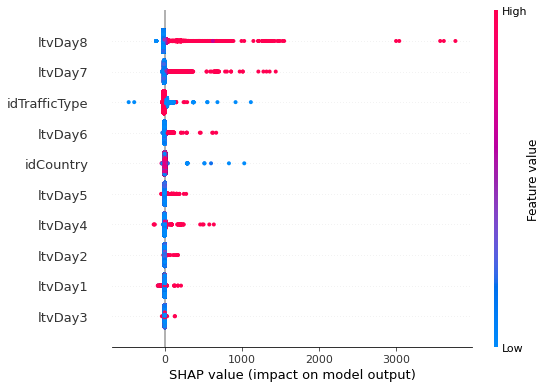

In [64]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

Чем больше признак подкрашен в одну из сторон (красную и синиюю), тем больше влияния он имеет на финальный прогноз модели.Видно, что самыми важными признаками тут является ltvDay8, оно и неудивительно - на этот день аккумулируется максимально доступная информацию по платежам пользователей.

Модель может давать прогноз, который меньше ltv 8 дня, поэтому необходимо ограничить возможной прогноз для каждого устройства уже фактическим для него значением LTV на 8 день. Далее получим данные с прогнозами:

In [65]:
df_test['predict_catboost'] = 0
for model in models_list:
    df_test['predict_catboost'] += model.predict(df_test[features])
df_test['predict_catboost'] /= len(random_state_list)
df_test['predict_catboost'] = round(df_test['predict_catboost'].clip(df_test[f'ltvDay{last_day}']),2)
df_test.head()

,device_id,dtInstall,idCountry,idTrafficType,ltvDay1,ltvDay2,ltvDay3,ltvDay4,ltvDay5,ltvDay6,ltvDay7,ltvDay8,ltvDay180,predict_catboost
0,device_0000001,2021-10-16,76,1,0.00,0.00,0.00,0.00,0.00,0.00,12.39,15.88,83.89,101.07
2,device_0000003,2021-10-02,81,2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,255.41,64.05
7,device_0000008,2021-10-07,200,1,111.42,111.42,111.42,166.63,166.63,166.63,166.63,166.63,2789.79,765.21
8,device_0000009,2021-10-02,67,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,61.46,77.96
9,device_0000010,2021-10-12,76,1,25.83,25.83,51.28,51.28,51.28,337.78,388.66,414.10,1196.51,2042.60


### Линейная модель

Теперь рассмотрим другой подход. Будем использовать простую линейную регрессию на признаках кумулятивных платежей. Так же строим 6 моделей по разным разбиениям данных, потом при прогнозировании будем брать среднее среди них.

In [66]:
ridge_list = []
for random_state in random_state_list:

    X_train, X_valid, y_train, y_valid = train_test_split(df_fit[features],
                                                          df_fit[target],
                                                          test_size=0.2, 
                                                          random_state=random_state)

    model = Ridge(fit_intercept=False)
    model.fit(X_train[ltv_features].astype('int'),
              y_train.astype('int'))
    ridge_list.append(model)
    
df_test['predict_ridge'] = 0
for model in ridge_list:
    df_test['predict_ridge'] += model.predict(df_test[ltv_features].astype('int')).reshape(-1)
df_test['predict_ridge'] /= len(random_state_list)
df_test['predict_ridge'] = round(df_test['predict_ridge'].clip(df_test[f'ltvDay{last_day}']), 2)

Рассмотрим значения коеффициентов каждого признака у последней модели. 

In [67]:
model_feature_coef = {item[0]: item[1] for item in zip(ltv_features, list(model.coef_[0]))}
for key, value in model_feature_coef.items():
    print(f"{key}: {value}")

ltvDay1: -0.5729238765495452
ltvDay2: 0.4966323790926837
ltvDay3: -1.411067907152586
ltvDay4: -0.569237305929537
ltvDay5: -0.09871755503867559
ltvDay6: -2.554070323527852
ltvDay7: 3.431151127557234
ltvDay8: 4.2524979036319355


Видно, что как и бустинга, самая важная фича - это кумулятивный платеж к 8 дню.

## Функция подсчета  ошибки

Для того, чтобы посчитать метрики, формулы которых указаны в начале, напишем функцию подсчета ошибок.

In [68]:
def get_errors(df, predict_columns=[],
               target_column=['ltvDay180'], 
               date_column=['dtInstall'], 
               weighted=[]):
    
    if len(predict_columns) == 0:
        raise Exception("Zero len of predict columns! Can't calculate any error")
        
    columns = predict_columns + target_column
    
    # считаем обычную ошибку
    if len(weighted) == 0:
        df_error = df.groupby(date_column[0])[columns].sum().reset_index()
        for col in predict_columns:

            error = np.abs((df_error[col] / df_error[target_column[0]]) - 1)
            df_error[col + '_error'] = error
        
        df_error.drop(columns, axis=1, inplace=True)
        return df_error
    
    # считаем средневзвешенную ошибку
    else:
        groupby_cols = [date_column[0]] + weighted
        df_error = df.groupby(groupby_cols)[columns].sum().reset_index()
        drop_columns = target_column
        
        # в этом датафрейме будем хранить ошибки
        buff_df = pd.DataFrame()
        buff_df[date_column[0]] = sorted(df[date_column[0]].unique())
        for col in predict_columns:
            df_error[col + '_error'] = np.abs((df_error[col] / df_error[target_column[0]] - 1))

            df_error['mult_' + col] = df_error[col + '_error'] * df_error[target_column[0]]
            
            temp_df = df_error.groupby(date_column[0])[target_column[0], 
                                                    'mult_' + col].sum().reset_index()
            
            temp_df[col + '_error_weighted'] = temp_df['mult_' + col]/temp_df[target_column[0]]
            
            buff_df = buff_df.merge(temp_df[[date_column[0], col + '_error_weighted']], 
                                   how='left', on=date_column[0])
    
        return buff_df

# Качество моделей

Посчитаем дневные ошибки для линейной модели и модели катбуста.

In [69]:
predict_columns = ['predict_catboost', 'predict_ridge']
df_day_errors = get_errors(df_test, predict_columns=predict_columns)

Отрисуем ошибки

In [70]:
layout = go.Layout()
fig = go.Figure()

# две кривые
for col in predict_columns:
    name = col.split('_')[1] + '_error'
    fig.add_trace(go.Scatter(x=df_day_errors.dtInstall, y=df_day_errors[col + '_error'], name=name))

# свойства графика
fig.update_layout(
    title_text="Day-app errors catboost and ridge.",
    title_font_size=20,
    yaxis_title='Error',
    xaxis_title='date'
)
fig

In [71]:
df_day_errors.mean()

predict_catboost_error    0.292205
predict_ridge_error       0.488065
dtype: float64

Посчитаем средневзвешенную ошибку по типам трафика:

In [72]:
predict_columns = ['predict_catboost', 'predict_ridge']
df_day_traf_errors = get_errors(df_test, predict_columns=predict_columns, weighted=['idTrafficType'])

Отрисуем ошибку:

In [73]:
layout = go.Layout()
fig = go.Figure()

# две кривые
for col in predict_columns:
    name = col.split('_')[1] + '_error_weighted'
    fig.add_trace(go.Scatter(x=df_day_traf_errors.dtInstall, 
                             y=df_day_traf_errors[col + '_error_weighted'], name=name))

# свойства графика
fig.update_layout(
    title_text="Day-app-traff errors catboost and ridge.",
    title_font_size=20,
    yaxis_title='Error',
    xaxis_title='date'
)

In [74]:
df_day_traf_errors.mean()

predict_catboost_error_weighted    0.343704
predict_ridge_error_weighted       0.506448
dtype: float64

Модели бустинга и линейные модели хороши тогда, когда есть достаточное количество наблюдаемых данных - в нашем случае это достаточное количество платящих пользователей за большой период времени.